# The Harmony MaskFill service

The Harmony MaskFill service takes gridded cloud-hosted input Earth Observation (EO) data granules, alongside a GeoJSON shape file, and masks all pixels outside the requested GeoJSON shape. These pixels are set to the fill value associated with each variable in question.

This Jupyter notebook will demonstrate two ways in which data can be retrieved from the Harmony MaskFill service: by constructing HTTP requests using the Python `requests` package, or by using the NASA `harmony-py` Python package. For users wanting the easiest experience, the `harmony-py` package is the recommended method, as it removes some of the boiler-plate functionality required to configure authentication and API polling.

### Environment setup:

This notebook assumes that it is being run in a local Python environment, configured using either `pyenv` or conda. Either can be used, but the dependencies will be installed via Pip. To install the required packages to run this notebook:

```bash
$ pip install -r requirements.txt
```

Note - your environment will require both the [proj](https://proj.org/) and [geos](https://trac.osgeo.org/geos/) packages to be able to install all the dependencies for this notebook (particularly `cartopy`).

`harmony-py` is available from [PyPI](https://pypi.org/project/harmony-py/). It can also be installed with Pip:

```bash
$ pip install harmony-py
```

### Notebook setup:

To make requests against the Harmony API, we need some boiler-plate up front to log in to Earthdata Login. The function below will allow Python scripts to log into any Earthdata Login application programmatically. It will only be used for making requests to the Harmony API using the `requests` Python package. `harmony-py` contains functionality to remove this step from the user.

To avoid being prompted for credentials every time you run and also allow clients such as curl to log in, you can add the following to a `.netrc` (`_netrc` on Windows) file in your home directory:

```
machine uat.urs.earthdata.nasa.gov
    login narmstrong
    password ap0ll0
```

Make sure that this file is only readable by the current user or you will receive an error stating "netrc access too permissive."

```
$ chmod 0600 ~/.netrc
```

The function is called at the end of the cell. Note that the Earthdata Login environment must match the Harmony environment containing the collection and service later in the notebook (e.g. UAT or production).

In [1]:
from urllib import request as urlrequest
from http.cookiejar import CookieJar
import getpass
import netrc


def setup_earthdata_login_auth(endpoint):
    """
    Set up the request library so that it authenticates against the given Earthdata Login
    endpoint and is able to track cookies between requests.  This looks in the .netrc file
    first and if no credentials are found, it prompts for them.

    Valid endpoints include:
        uat.urs.earthdata.nasa.gov - Earthdata Login UAT (Harmony's current default)
        urs.earthdata.nasa.gov - Earthdata Login production
    """
    try:
        username, _, password = netrc.netrc().authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print('Please provide your Earthdata Login credentials to allow data access')
        print('Your credentials will only be passed to %s and will not be exposed in Jupyter' % (endpoint))
        username = input('Username:')
        password = getpass.getpass()

    manager = urlrequest.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = urlrequest.HTTPBasicAuthHandler(manager)

    jar = CookieJar()
    processor = urlrequest.HTTPCookieProcessor(jar)
    opener = urlrequest.build_opener(auth, processor)
    urlrequest.install_opener(opener)


setup_earthdata_login_auth('uat.urs.earthdata.nasa.gov')

#### Plotting functions

The function below can be used to plot information from either the granule itself, or regarding the shape file.

In [2]:
import cartopy.crs as ccrs
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline


def plot_variable(variable_data, longitudes, latitudes):
    """ Plots variable against longitudes and latitudes in masked area on the world map. """
    plt.figure(figsize=(10, 10))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    ax.coastlines(resolution='110m')
    ax.contourf(longitudes, latitudes, variable_data, alpha=0.5)
    plt.show()


def plot_shape_file(shape_file_path):
    """ Plots a shape file from a GeoJSON input file. """
    shape = gpd.read_file(shape_file_path).to_crs(epsg=3857)
    plot = shape.plot(alpha=0.5, edgecolor='k', figsize=(8, 8))
    ctx.add_basemap(plot)

#### Helper for asynchronous requests:

Harmony can be run asynchronously, which is preferable for slower services that perform complex operations. The following helper function will take a job ID and periodically poll the Harmony API to see if the request is complete. Upon completion, it will return a list of URLs for processed output files. This function is not used by the `harmony-py` example below.

In [3]:
from time import sleep
import progressbar
import requests


def get_harmony_output_urls(job_id):
    """ Take a job ID and wait for completion of the request. When the request is complete, return a
        URL for the output.

    """
    widgets = [
        ' [',
        progressbar.Timer(format= 'elapsed time: %(elapsed)s'),
        '] ',
        progressbar.Bar('*'),' (',
        progressbar.ETA(), ') ',
    ]
    bar = progressbar.ProgressBar(max_value=100, widgets=widgets).start()
    progress = 0
    status = 'running'
    while status == 'running':
        status_response = requests.get(f'https://harmony.uat.earthdata.nasa.gov/jobs/{job_id}')
        status_json = status_response.json()
        status = status_json.get('status')
        progress = float(status_json.get('progress'))
        bar.update(progress)
        sleep(3)

    if status == 'successful':
        return [link['href'] for link in status_json.get('links', []) if link['rel'] == 'data']
    else:
        print(f'Response was unsuccessful: {status_response.content}')
        return []

# Using the Harmony API directly

It is possible to construct URLs to make requests directly against the Harmony API. The requests require a few pieces of information:

* The concept ID of the data collection containing the granules to be processed. This has the format "C1234567890-[PROVIDER]".
* The concept ID of the granule(s) being requested. This has the format "G1234567890-[PROVIDER]".
* A shape file, saved as a GeoJSON file. (See below for more details on shape files).
* Harmony endpoint URL.

### Shape files:

When making requests directly to Harmony, these shape files should contain one or more `Polygon` features. `MultiPolygon` features will not be accepted by the API, and should be split into a list of separate `Polygon` features. In addition all polygons should have their points ordered in an anticlockwise direction.

## The test case:

This test request will retrieve a granule from the [SMAP level 4, Net Carbon Ecosystem Exchange collection](https://nsidc.org/data/spl4cmdl) (SPL4CMDL). The SPL4CMDL collections shows estimates of Carbon Dioxide exchange, on the EASE-2 global (cylindrical) grid.

The region of interest, as specified in the shape file, will be the USA.

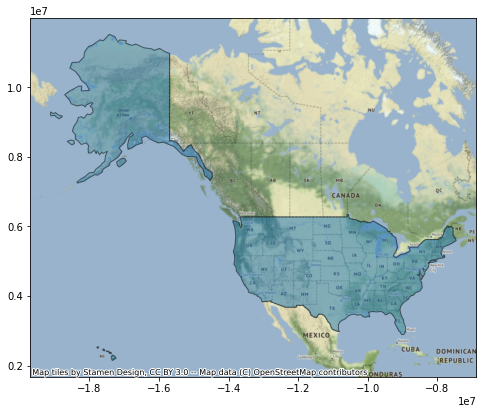

In [4]:
plot_shape_file('USA.geojson')

## Constructing the Harmony URL:

The MaskFill Harmony service requires a URL of the following format:

```
https://harmony.earthdata.nasa.gov/[COLLECTION ID]/ogc-api-coverages/[OGC API VERSION]/collections/[VARIABLES]/coverage/rangeset
```

Note, the Harmony URL shown above is for production. We will be using a test collection in the UAT environment, so the base Harmony URL becomes: `https://harmony.uat.earthdata.nasa.gov`.

The collection ID is the concept ID, as discussed above. The OGC API version is a semantic version number (currently 1.0.0). For the SPL4CMDL test collection, there are no other variable subsetting services chained to Harmony MaskFill. So we must request all variables using the string "all".

The granule is selected as a data parameter, as is the decision to make the request asynchronous:

```python
data = {'granuleid': 'G1234567890-PROVIDER', 'forceAsync': 'true'}
```

Finally, the GeoJSON shape file must be added using the `requests.post` `file` keyword argument:

```python
files = {'shapefile': ('USA.geojson', open('USA.geojson', 'r'), 'application/geo+json')}
```

In the tuple for the shape file, the first element acts as an identifier for the shape file, the second element contains the actual GeoJSON shape and the third specifies the MIME type for the data. The Harmony MaskFill service is currently configured only to accept GeoJSON shapefiles.

In [5]:
# Specify variables to be used in the Harmony URL:
harmony_host_url = 'https://harmony.uat.earthdata.nasa.gov'
collection_id = 'C1240150677-EEDTEST'
granule_id = 'G1240154800-EEDTEST'
variable = 'all'

# Construct the URL, shape file and data parameters for the request
request_url = f'{harmony_host_url}/{collection_id}/ogc-api-coverages/1.0.0/collections/{variable}/coverage/rangeset'
shape_file = 'USA.geojson', open('USA.geojson', 'r'), 'application/geo+json'
data = {'granuleid': granule_id, 'forceAsync': 'true'}

# Make the initial asynchronous request, which should return a job ID:
response = requests.post(request_url, data=data, files={'shapefile': shape_file})

# If the request was successful, wait for the Harmony request to finish, and return URLs to the processed data:
# The request will probably take approximately 1 minute to complete, as the file size is 130 MB.
if response.status_code == 200:
    job_id = response.json().get('jobID')
    output_urls = get_harmony_output_urls(job_id)
    print(f'Output data URLs: {output_urls}')
else:
    print(f'Error with request ({response.status_code}): {response.content}')

 [elapsed time: 0:00:46] |**********************************| (ETA:  00:00:00) 

Output data URLs: ['https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-staging/public/sds/maskfill/976093c5-1571-4444-b970-718a8913cbac/SMAP_L4_C_mdl_20210224T000000_Vv5024_001_subsetted.h5']


## Assessing the output:

Now the request is complete, we need to download the output and plot it. We can use the output URL given by Harmony to download the data. The content of this request will be the file itself, which can be read directly with the `h5py` Python package.

Granules in the SPL4CMDL collection have a hierarchical data structure. Our example variable will be the environmental constraint multiplier, which has a path `/EC/emult_mean`. This is supported by the coordinate variables `/GEO/longitude` and `/GEO/latitude`, which define the longitudes and latitudes of each point in the grid.

In [6]:
from h5py import File as H5File
from io import BytesIO


# This request will probably also take approximately 1 minute to retrieve the 130 MB output.
output_data_response = requests.get(output_urls[0])

# Read the output content:
data = H5File(BytesIO(output_data_response.content), 'r')

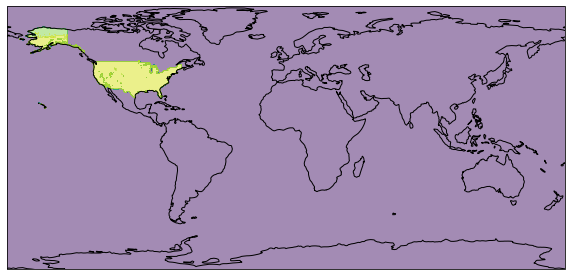

In [7]:
# Plot the masked environmental constraint multiplier:
plot_variable(data['/EC/emult_mean'], data['/GEO/longitude'], data['/GEO/latitude'])

# Using `harmony-py` to make MaskFill requests

In this second part of the notebook, we will use the same input collection and granule, alongside the same GeoJSON shape, but simplify the request process using the `harmony-py` package.

As noted above, the `harmony-py` package can be installed from the Python Package Index using Pip:

```bash
$ pip install -U harmony-py
```

`harmony-py` creates a client, which requires Earthdata Login credientials. If a `.netrc` file exists in the home directory of your machine, the `harmony-py` client will attempt to retrieve Earthdata Login credentials from it.

### The `harmony-py` `Client`:

This class will handle the communication with the Harmony API, including authentication, as derived from a `.netrc` file. Requests are made by submitting a `Request` instance to Harmony using the `Client` instance. The `harmony-py` `Client` can be configured for any of the available Harmony environments, e.g. UAT or production.

### Forming a `Request` instance:

An instance of the `Request` object can be used to make requests to the Harmony API via the a harmony `Client` instance. To create a `Request` object, the collection must be specified. Additional arguments can be included. For example the concept IDs of granules or variables to be processed. Omitting granule IDs will result in Harmony trying to process all granules in a collection. Similarly, not specifying variables is the equivalent of requesting all variables in each granule.

In [8]:
from harmony import BBox, Client, Collection, Request, Environment


# Define the collection and granule concept IDs:
collection_id = 'C1240150677-EEDTEST'
granule_id = 'G1240154800-EEDTEST'

# Create a client for the UAT environment:
harmony_client = Client(env=Environment.UAT)

# Specify the path to the locally saved GeoJSON shape file:
shapefile = 'USA.geojson'

# Create a collection instance, using the concept ID:
collection = Collection(id=collection_id)

# Construct a request, ready to send to the Harmony API:
request = Request(collection=collection, granule_id=[granule_id], shape='USA.geojson')

# Ensure the request is valid:
print(f'Request is valid: {request.is_valid()}')

Request is valid: True


## Submit requests and tracking progress

Submitting a valid request to Harmony using the `Client` instance will return a job ID. This ID can be used to track the job status using in-built functionality.

In [9]:
# Submit a valid Harmony request via the UAT Harmony client.
job_id = harmony_client.submit(request)

# Show job progress
print(f'\nWaiting for the job {job_id} to finish')
results = harmony_client.result_json(job_id, show_progress=True)

{'username': 'olittlej', 'status': 'running', 'message': 'The job is being processed', 'progress': 0, 'createdAt': '2021-04-19T18:26:22.478Z', 'updatedAt': '2021-04-19T18:26:22.478Z', 'links': [{'title': 'Job Status', 'href': 'https://harmony.uat.earthdata.nasa.gov/jobs/e5eb6bae-e0b4-46ca-a8fd-038b02a1430f', 'rel': 'self', 'type': 'application/json'}], 'request': 'https://harmony.uat.earthdata.nasa.gov/C1240150677-EEDTEST/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?forceAsync=true&granuleId=G1240154800-EEDTEST', 'numInputGranules': 1, 'jobID': 'e5eb6bae-e0b4-46ca-a8fd-038b02a1430f'}

Waiting for the job e5eb6bae-e0b4-46ca-a8fd-038b02a1430f to finish


 [ Processing: 100% ] |###################################################| [|]


### Downloading data:

The following cell will download all the processed output. The `Client.download_all` method will save local copies of each granule, and will return information about those files.

In [10]:
print('\nDownloading results.')
futures = harmony_client.download_all(job_id, overwrite=True)
downloaded_files = [future.result() for future in futures]
print(f'Downloaded files: {downloaded_files}')


Downloaded files: ['SMAP_L4_C_mdl_20210224T000000_Vv5024_001_subsetted.h5']


### Response JSON:

If we're just interested in the json Harmony produces we can retrieve that also. This could be a useful way to retrieve the URLs of the processed data, without downloading those files until they are actually needed. It also provided information on the STAC catalogs for the output granules.

In [11]:
harmony_client.result_json(job_id)

{'username': 'olittlej',
 'status': 'successful',
 'message': 'The job has completed successfully',
 'progress': 100,
 'createdAt': '2021-04-19T18:26:22.478Z',
 'updatedAt': '2021-04-19T18:27:06.611Z',
 'links': [{'title': 'Job Status',
   'href': 'https://harmony.uat.earthdata.nasa.gov/jobs/e5eb6bae-e0b4-46ca-a8fd-038b02a1430f',
   'rel': 'self',
   'type': 'application/json'},
  {'title': 'STAC catalog',
   'href': 'https://harmony.uat.earthdata.nasa.gov/stac/e5eb6bae-e0b4-46ca-a8fd-038b02a1430f/',
   'rel': 'stac-catalog-json',
   'type': 'application/json'},
  {'href': 'https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-staging/public/sds/maskfill/9a6b11e3-b835-4558-b980-72f356265762/SMAP_L4_C_mdl_20210224T000000_Vv5024_001_subsetted.h5',
   'title': 'SMAP_L4_C_mdl_20210224T000000_Vv5024_001_subsetted.h5',
   'type': 'application/x-hdf5',
   'rel': 'data',
   'bbox': [-180, -85.04456, 180, 85.04456],
   'temporal': {'start': '2021-02-24T00:00:00.000Z',
    'end': '2

### Assessing the output:

The cell below will plot the environmental constraint multiplier from the downloaded file retrieved by `harmony-py`. It should be identical to the output from using the Harmony API directly.

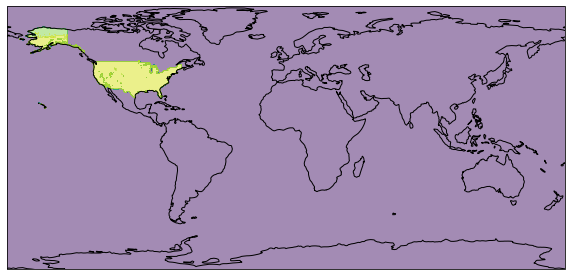

In [12]:
from h5py import File as H5File


# Open the first output file:
harmony_py_data = H5File(downloaded_files[0], 'r')

# Plot the masked environmental constraint multiplier:
plot_variable(harmony_py_data['/EC/emult_mean'], harmony_py_data['/GEO/longitude'], harmony_py_data['/GEO/latitude'])